# **Overview**

In this tutorial, we will guide you through using the Twelve Labs Search Functionality to efficiently locate video content related to the Olympics Tournament across diverse categories.

We will:

1. Setup the Olympics Video Clips for the Index
2. Creation of the Index
3. Indexing the Olympics Video Clips with Marengo-2.7
4. Twelve Labs Search Functionality to interact with the Index



## Install Library

In [1]:
#Installing the Twelve Labs and the dotenv library
!pip install twelvelabs python-dotenv

In [2]:
# Importing the necessary librarie
from twelvelabs import TwelveLabs
from twelvelabs.models.search import SearchData, GroupByVideoSearchData
from twelvelabs.models.task import Task
import requests
import os
from dotenv import load_dotenv
import time
import glob

## Preparing the Video Data


Using Olympics Video Data

This demo uses video data from a Olympics Tournament stored in the google drive folder for an ease usage to store in the Index. To use it, you'll need to link the folder to your google drive, and then mount your google drive to this colab.

### Linking the folder to our Google Drive:
Anyone can access the folder with this link: https://drive.google.com/drive/folders/1EFkGkzb-vwknMMheF2wkQi84SwYtBGDK?usp=drive_link

To Link this to the correct spot in _your_ google drive:
1. Go to "Shared with me" in Google Drive.
2. Locate the shared folder you want to access.
3. Select "Organize" -> "Add Shortcut"
4. Choose "My Drive" as the destination and click "Add".

Now this folder should be accessible at `/content/drive/MyDrive/Twelve_Labs_Sports`

### Mounting Drive
The cell below will mount your Drive, which we can then use to load the videos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set the video path

video_dir = "/content/drive/MyDrive/Twelve_Labs_Sports/"

## Initialize Twelve Labs client

Generate the API KEY from the Twelve Labs Playground - https://playground.twelvelabs.io/



In [5]:
# Setting up the API Credentials and endpoints
API_KEY = os.getenv("API_KEY", "Your Twelve Labs API KEY")
BASE_URL = "https://api.twelvelabs.io/v1.3"

In [6]:
client = TwelveLabs(api_key=API_KEY)

## Uploading Olympics Video to Marengo-2.7

First we will create an index for our video uploads and the Marengo Engine, then upload them.

## Define the model configuration for Marengo 2.7 with visual and audio options

In [7]:
models = [
    {
        "name": "marengo2.7",
        "options": ["visual", "audio"]
    }
]

In [8]:
# Create a new index with a unique name
index_name = "Olympic_Videos_" + str(int(time.time()))

Create the index with Marengo model and thumbnail addon

In [9]:
try:
    index = client.index.create(
        name=index_name,
        models=models,
        addons=["thumbnail"]
    )
    index_id = index.id
    print(f"New index created successfully: ID={index_id}, Name={index.name}")
except Exception as e:
    print(f"Error creating index: {str(e)}")

New index created successfully: ID=67ec2fcd90642e5b03851e29, Name=Olympic_Videos_1743531980


In [10]:
# Get list of videos from the directory
video_files = glob.glob(os.path.join(video_dir, "*.mp4"))
print(f"Found {len(video_files)} video files")

Found 18 video files


In [11]:
# Setting up the API Credentials and endpoints
INDEX_ID = index_id

In [12]:
# Status Monitoring of the single video task upload
def on_task_update(task: Task):
    print(f"  Status={task.status}")

## Indexing Videos

Indexing videos one by one can be time-consuming, especially with 18 videos to process. To streamline the process, you can modify the number of videos in the source location when loading the directory based on your convenience.

In [13]:
# Indexing all the videos in the directory

successful_uploads = []
failed_uploads = []

for video_path in video_files:
    video_name = os.path.basename(video_path)
    print(f"\nUploading {video_name}...")

    # Upload the video to the index
    with open(video_path, "rb") as video_file:

        task = client.task.create(
            index_id=index_id,
            file=video_file
        )
    print(f"Upload started - Task ID: {task.id}")

    # Wait for indexing to complete
    print(f"Monitoring indexing progress for {video_name}:")
    task.wait_for_done(sleep_interval=5, callback=on_task_update)

    if task.status == "ready":
        print(f"{video_name} successfully indexed - Video ID: {task.video_id}")
        successful_uploads.append({"name": video_name, "id": task.video_id})
    else:
        print(f"Indexing failed for {video_name} with status: {task.status}")
        failed_uploads.append({"name": video_name, "status": task.status})


# Step 4 - Stats

print(f"Index Name - {index_name}")
print(f"Total videos processed - {len(video_files)}")
print(f"Successfully indexed - {len(successful_uploads)}")

if successful_uploads:
    print("\nSuccessfully indexed videos:")
    for i, video in enumerate(successful_uploads):
        print(f"{i+1}. {video['name']} - ID: {video['id']}")

if failed_uploads:
    print("\nFailed videos:")
    for i, video in enumerate(failed_uploads):
        print(f"{i+1}. {video['name']} - Issue: {video.get('status') or video.get('error')}")

print("\n🔍 Your index is ready for search")


Uploading Olympics 1.mp4...
Upload started - Task ID: 67ec2fd04213f76005081a48
Monitoring indexing progress for Olympics 1.mp4:
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=indexing
  Status=indexing
  Status=indexing
  Status=indexing
  Status=ready
Olympics 1.mp4 successfully indexed - Video ID: 67ec2fd04213f76005081a48

Uploading Olympics 2.mp4...
Upload started - Task ID: 67ec300931cc2c99458b827a
Monitoring indexing progress for Olympics 2.mp4:
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=indexing
  Status=indexing
  Status=indexing
  Status=indexing
  Status=ready
Olympics 2.mp4 successfully indexed - Video ID: 67ec300931cc2c99458b827a

Uploading Olympics 3.mp4...
Upload started - Task ID: 67ec3042359be748720adf37
Monitoring indexing progress for Olympics 3.mp4:
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=pending
  Status=indexing
  Status=indexing
  

An alternative way to create the Index is by accessing the Twelve Labs Playground, selecting Marengo 2.7, uploading a video in the second step, and retrieving the Index ID for the searchability task.

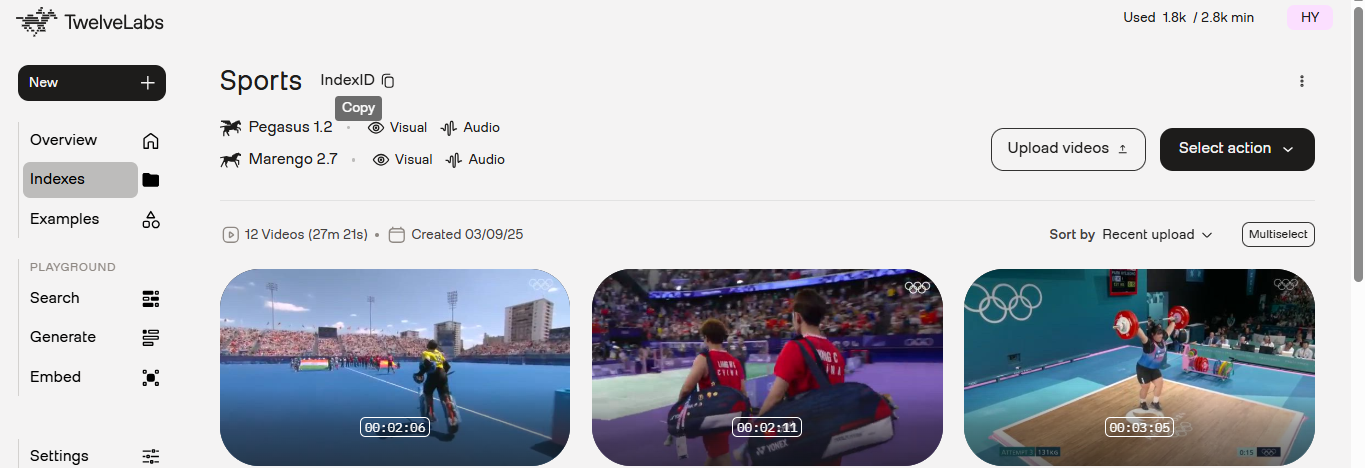

## Defining Categories and Prompt

To enhance searchability, Olympic sports categories can be defined with clear titles and supplemented with descriptive prompts that provide better context. Directly mentioning the category name in a search will yield results, but adding detailed prompts improves accuracy and relevance.

In [14]:
olympic_categories = [
    {"name": "AquaticSports", "prompt": "swimming competition"},
    {"name": "AthleticEvents", "prompt": "track and field"},
    {"name": "GymnasticsEvents", "prompt": "artistic gymnastics"},
    {"name": "CombatSports", "prompt": "boxing match"},
    {"name": "TeamSports", "prompt": "basketball game"},
    {"name": "CyclingSports", "prompt": "road cycling race"},
    {"name": "RacquetSports", "prompt": "tennis match"},
    {"name": "RowingAndSailing", "prompt": "rowing competition"}
]

In [15]:
print("Available Olympic sport categories:")
for i, category in enumerate(olympic_categories):
    print(f"{i+1}. {category['name']}")

Available Olympic sport categories:
1. AquaticSports
2. AthleticEvents
3. GymnasticsEvents
4. CombatSports
5. TeamSports
6. CyclingSports
7. RacquetSports
8. RowingAndSailing


Choose an Olympic sports category to retrieve high confidence Olympic content.

In [16]:
selection = input("Enter the number of the category you want to search (1-8): ")
selected_index = int(selection) - 1

Enter the number of the category you want to search (1-8): 3


In [ ]:
if selected_index < 0 or selected_index >= len(olympic_categories):
    print("Invalid selection. Using default category 'TeamSports'")
    selected_index = 4  # Default to TeamSports

Storing in the variable, the selected category and the respective prompt for the additional context about the same.

In [ ]:
selected_category = olympic_categories[selected_index]
selected_category_name = selected_category["name"]
selected_prompt = selected_category["prompt"]

print(f"Selected category: {selected_category_name}")
print(f"Using prompt: {selected_prompt}")

# **Search Functionality**

In [ ]:
try:
    print(f"Searching for prompt -  '{selected_prompt}'")

    # Search videos using Twelve Labs API
    result = client.search.query(
        index_id=INDEX_ID,
        options=["visual", "audio"],
        query_text=selected_prompt,
        group_by="video",
        threshold="medium",
        operator="or",
        page_limit=5,
        sort_option="score"
    )

    # Print search response details
    print(f"Search response for prompt '{selected_prompt}':")
    print(f"  Total results: {result.page_info.total_results}")
    print(f"  Index ID: {result.pool.index_id}")
    print(f"  Total count in pool: {result.pool.total_count}")

    # Check and print first result details if available
    if result.data and len(result.data) > 0:
        print(f"  First result type: {type(result.data[0])}")
        if isinstance(result.data[0], GroupByVideoSearchData) and result.data[0].clips:
            clip = result.data[0].clips[0]
            print(f"  Sample clip data: score={clip.score}, start={clip.start}, end={clip.end}")
            print(f"  Confidence type: {type(clip.confidence)}")
            print(f"  Confidence value: {clip.confidence}")
except Exception as e:
    print(f"API Error for prompt '{selected_prompt}': {str(e)}")
    print(f"Exception details: {type(e).__name__}: {str(e)}")
    exit(1)

In [20]:
# Number of videos retrieved on the base of the prompt provided

video_ids = []
i = 0
while i < len(result.data):
    item = result.data[i]
    if isinstance(item, GroupByVideoSearchData):
        video_ids.append(item.id)
    else:
        video_ids.append(item.video_id)
    i += 1

print(f"Found {len(video_ids)} videos for the '{selected_prompt}' prompt")

Found 5 videos for the 'artistic gymnastics' prompt


To fetch the video URL of the retreived result. The video retreived are in the format of the m3u8 format.

In [21]:
video_urls = {}
base_url = f"https://api.twelvelabs.io/v1.3/indexes/{INDEX_ID}/videos/{{}}"
headers = {"x-api-key": API_KEY, "Content-Type": "application/json"}

i = 0
while i < len(video_ids):
    video_id = video_ids[i]
    try:
        response = requests.get(base_url.format(video_id), headers=headers)
        response.raise_for_status()
        data = response.json()
        if 'hls' in data and 'video_url' in data['hls']:
            video_urls[video_id] = data['hls']['video_url']
            print(f"Retrieved URL for video ID: {video_id}")
        else:
            print(f"No video URL found for video ID: {video_id}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to get data for video ID: {video_id}. Error: {str(e)}")
    i += 1


Retrieved URL for video ID: 67ec32ed90642e5b03851ead
Retrieved URL for video ID: 67ec300931cc2c99458b827a
Retrieved URL for video ID: 67ec32b4359be748720adf64
Retrieved URL for video ID: 67ec3223359be748720adf61
Retrieved URL for video ID: 67ec328b4213f76005081aa9


# **Results**

In [22]:
video_count = 0
i = 0
while i < len(result.data) and video_count < 3:
    item = result.data[i]
    if isinstance(item, GroupByVideoSearchData):
        video_id = item.id
        if item.clips:
            print(f"\nVideo {video_count+1}: {video_id}")

            j = 0
            while j < min(3, len(item.clips)):
                clip = item.clips[j]
                confidence = clip.confidence
                print(f"  Clip {j+1}: {float(clip.start):.1f}s - {float(clip.end):.1f}s | Score: {float(clip.score):.1f} | Confidence: {confidence}")
                j += 1

            if video_id in video_urls:
                print(f"  Video URL: {video_urls[video_id]}")
            else:
                print("  Video URL not available")

            video_count += 1
    i += 1

if video_count == 0:
    print(f"No videos found for prompt: {selected_prompt}")

print("\nSearch and analysis complete")


Video 1: 67ec32ed90642e5b03851ead
  Clip 1: 157.5s - 163.4s | Score: 84.5 | Confidence: high
  Clip 2: 61.3s - 69.2s | Score: 84.4 | Confidence: high
  Clip 3: 42.5s - 55.9s | Score: 84.3 | Confidence: high
  Video URL: https://deuqpmn4rs7j5.cloudfront.net/6633a646e06d1c2c0212c7df/67ec32ed90642e5b03851ead/stream/f0464378-2ca2-4539-abb6-d1dd4487e776.m3u8

Video 2: 67ec300931cc2c99458b827a
  Clip 1: 150.9s - 155.0s | Score: 84.4 | Confidence: high
  Clip 2: 0.0s - 5.1s | Score: 84.2 | Confidence: high
  Clip 3: 138.9s - 143.9s | Score: 84.2 | Confidence: high
  Video URL: https://deuqpmn4rs7j5.cloudfront.net/6633a646e06d1c2c0212c7df/67ec300931cc2c99458b827a/stream/07880a1e-b110-46cc-be7d-9f425df62bfc.m3u8

Video 3: 67ec32b4359be748720adf64
  Clip 1: 180.2s - 185.0s | Score: 84.3 | Confidence: high
  Clip 2: 54.4s - 65.6s | Score: 84.2 | Confidence: high
  Clip 3: 145.7s - 169.6s | Score: 84.2 | Confidence: high
  Video URL: https://deuqpmn4rs7j5.cloudfront.net/6633a646e06d1c2c0212c7df/6

## Rendering the m3u8 format in the result in fetched content

In [23]:
from IPython.display import HTML

video_count = 0
i = 0
video_player_html = """
<script src="https://cdn.jsdelivr.net/npm/hls.js@latest"></script>
"""

while i < len(result.data) and video_count < 3:
    item = result.data[i]
    if isinstance(item, GroupByVideoSearchData):
        video_id = item.id
        if item.clips:
            video_player_html += f"<h3>Video {video_count+1}: {video_id}</h3>"
            j = 0
            while j < min(3, len(item.clips)):
                clip = item.clips[j]
                confidence = clip.confidence
                video_player_html += f"<p>Clip {j+1}: {float(clip.start):.1f}s - {float(clip.end):.1f}s | Score: {float(clip.score):.1f} | Confidence: {confidence}</p>"
                j += 1
            if video_id in video_urls:
                video_url = video_urls[video_id]
                video_player_html += f"""
                <video id="video-{video_count}" width="640" height="360" controls></video>
                <script>
                    var video = document.getElementById('video-{video_count}');
                    if (Hls.isSupported()) {{
                        var hls = new Hls();
                        hls.loadSource('{video_url}');
                        hls.attachMedia(video);
                    }} else if (video.canPlayType('application/vnd.apple.mpegurl')) {{
                        video.src = '{video_url}';
                    }}
                </script>
                """
            else:
                video_player_html += "<p>Video URL not available</p>"
            video_count += 1
    i += 1

if video_count == 0:
    video_player_html = f"<p>No videos found for prompt: {selected_prompt}</p>"

video_player_html += "<p><strong>Search and analysis complete</strong></p>"

HTML(video_player_html)
